In [1]:
import pandas
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import Sequential
#from keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier
#from keras.utils import np_utils
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.preprocessing import LabelEncoder
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from tensorflow.keras.layers.experimental import preprocessing
from tensorflow.keras.layers.experimental.preprocessing import Normalization
import os
import glob
import matplotlib.pyplot as plt
import kerastuner as kt
import math
import pydot
from tensorflow.keras.utils import plot_model
import plotly.express as px
import plotly.graph_objects as go
import plotly.figure_factory as ff

In [2]:
dataset = pandas.read_csv('/home/dell/Neural_net/train_coin_10/train_coin_dataset.csv')

X1=dataset.drop(['target'],axis=1)
train1,test1=train_test_split(X1,test_size=0.2,shuffle=True)
train1,val1=train_test_split(train1,test_size=0.2)
#X1.head()

In [3]:
batch_size=30

def df_to_pred_dataset(dataframe, shuffle=True, batch_size=batch_size):
  dataframe = dataframe.copy()
  #labels=dataframe.pop('final_snr')
  labels = pandas.concat([dataframe.pop(x) for x in ['inj_m1', 'inj_m2','final_snr']], axis=1)
  #labels = pandas.concat([dataframe.pop(x) for x in ['inj_m1', 'inj_m2']], axis=1)
  ds = tf.data.Dataset.from_tensor_slices((dict(dataframe), labels))
  if shuffle:
    ds = ds.shuffle(buffer_size=len(dataframe))
  ds = ds.batch(batch_size)
  ds = ds.prefetch(batch_size)
  return ds

In [4]:
train_pred_ds=df_to_pred_dataset(train1,batch_size=batch_size)
val_pred_ds = df_to_pred_dataset(val1, shuffle=False, batch_size=batch_size)
test_pred_ds = df_to_pred_dataset(test1, shuffle=False, batch_size=batch_size)


In [5]:
all_inputs=[]
encoded_features=[]

In [6]:
def get_normalization_layer(name, dataset):
      normalizer = preprocessing.Normalization()
      # Prepare a Dataset that only yields our feature.
      feature_ds = dataset.map(lambda x, y: x[name])
      #print(feature_ds)
      #feature_ds=tf.convert_to_tensor(feature_ds)
      # Learn the statistics of the data.
      normalizer.adapt(feature_ds)
      #print('----------------------------')
      print(normalizer.dtype)
      #print('----------------------------')
      return normalizer

In [7]:
for header in ['mass1','mass2','match']:
      print(header)
      numeric_col = tf.keras.Input(shape=(1,), name=header)
      normalization_layer = get_normalization_layer(header, train_pred_ds)
      encoded_numeric_col = normalization_layer(numeric_col)
      all_inputs.append(numeric_col)
      encoded_features.append(encoded_numeric_col)
#encoded_features

mass1
float32
mass2
float32
match
float32


In [8]:
all_features = tf.keras.layers.concatenate(encoded_features)

In [9]:
def model_pred(hp):
    x1 = tf.keras.layers.Dense(units=hp.Int('units_1', min_value=32, max_value=512, step=32),
                               activation="relu")(all_features)
    x1 = tf.keras.layers.Dense(units=hp.Int('units_2', min_value=32, max_value=512, step=32),
                               activation="relu")(x1)
    x1 = tf.keras.layers.Dropout(hp.Float('dropout', 0, 0.5, step=0.1, default=0.5))(x1)
    output1 = tf.keras.layers.Dense(3, activation="relu")(x1)
    model = tf.keras.Model(all_inputs, output1)
    model.compile(optimizer=keras.optimizers.Adam(hp.Choice('learning_rate', [1e-2, 1e-3, 1e-4])),
                  loss=tf.keras.losses.MeanSquaredError(),metrics=["accuracy"])
    
    return model



In [10]:
stop_early = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)

In [11]:
tuner = kt.Hyperband(model_pred,
                     objective='val_accuracy',
                     max_epochs=10,
                     factor=3,
                     directory='my_dir',
                     project_name='prediction_mse_2')

INFO:tensorflow:Reloading Oracle from existing project my_dir/prediction_mse_2/oracle.json
INFO:tensorflow:Reloading Tuner from my_dir/prediction_mse_2/tuner0.json


In [12]:
tuner.search(train_pred_ds, epochs=50, validation_data=val_pred_ds, callbacks=[stop_early])

# Get the optimal hyperparameters
best_hps=tuner.get_best_hyperparameters(num_trials=1)[0]

print(f"""
The hyperparameter search is complete. The optimal number of units in the first densely-connected
layer is {best_hps.get('units_1')}, for second layer is {best_hps.get('units_2')} and the optimal learning rate for the optimizer
is {best_hps.get('learning_rate')}. Also the dropout value is {best_hps.get('dropout')}
""")

INFO:tensorflow:Oracle triggered exit

The hyperparameter search is complete. The optimal number of units in the first densely-connected
layer is 288, for second layer is 64 and the optimal learning rate for the optimizer
is 0.0001. Also the dropout value is 0.2



Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
mass1 (InputLayer)              [(None, 1)]          0                                            
__________________________________________________________________________________________________
mass2 (InputLayer)              [(None, 1)]          0                                            
__________________________________________________________________________________________________
match (InputLayer)              [(None, 1)]          0                                            
__________________________________________________________________________________________________
normalization (Normalization)   (None, 1)            3           mass1[0][0]                      
______________________________________________________________________________________________

14400/14400 [==============================] - 20s 1ms/step - loss: 104.0332 - accuracy: 1.0000 - val_loss: 95.2930 - val_accuracy: 1.0000
Epoch 37/80
14400/14400 [==============================] - 21s 1ms/step - loss: 103.5345 - accuracy: 1.0000 - val_loss: 95.4025 - val_accuracy: 1.0000
Epoch 38/80
14400/14400 [==============================] - 22s 1ms/step - loss: 103.3276 - accuracy: 1.0000 - val_loss: 95.3024 - val_accuracy: 1.0000
Epoch 39/80
14400/14400 [==============================] - 21s 1ms/step - loss: 103.4882 - accuracy: 1.0000 - val_loss: 95.2800 - val_accuracy: 1.0000
Epoch 40/80
14400/14400 [==============================] - 20s 1ms/step - loss: 103.4526 - accuracy: 1.0000 - val_loss: 95.1543 - val_accuracy: 1.0000
Epoch 41/80
14400/14400 [==============================] - 20s 1ms/step - loss: 103.0293 - accuracy: 1.0000 - val_loss: 95.3993 - val_accuracy: 1.0000
Epoch 42/80
14400/14400 [==============================] - 21s 1ms/step - loss: 103.6286 - accuracy: 1.000

IndexError: list index out of range

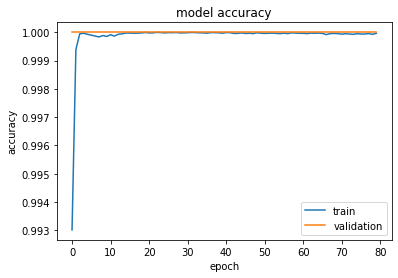

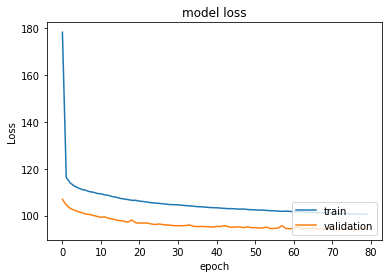

In [13]:
model = tuner.hypermodel.build(best_hps)
plot_model(model, to_file='pred_me_model_plot.png', show_shapes=True, show_layer_names=True)
model.summary()
history = model.fit(train_pred_ds, epochs=80, validation_data=val_pred_ds)
#model.summary()
val_acc_per_epoch = history.history['val_accuracy']
best_epoch = val_acc_per_epoch.index(max(val_acc_per_epoch)) + 1
print('Best epoch: %d' % (best_epoch,))
model.save("Prediction_mse_model_latest")
#  "Accuracy"
plt.figure()
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='lower right')
plt.savefig('/home/dell/Neural_net/train_coin_4/Accuracy_p_mse2_plot')
#  "loss"
plt.figure()
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('Loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='lower right')
plt.savefig('/home/dell/Neural_net/train_coin_4/Loss_p_mse2_plot')
#test
y_hat=model.predict("test_pred_ds")
m1=test1.inj_m1
m2=test1.inj_m2
snr=test1.final_snr
plt.figure()
plt.plot(m1,y_hat[:,0])
plt.plot(m2,y_hat[:,1])
plt.plot(snr,y_hat[:,2])
plt.title('Test')
plt.ylabel('Prediction')
plt.xlabel('Actual')
plt.legend(['Mass1', 'Mass2', 'SNR'], loc='lower right')
plt.savefig('/home/dell/Neural_net/train_coin_4/test_p_mse2_plot')

In [35]:
#model= keras.models.load_model('/home/dell/Neural_net/plots_coin_8/Prediction_mse_relu_model')
os.chdir("/home/dell/Neural_net/test_coin_10")
extension = 'csv'
all_filenames = [i for i in glob.glob('*.{}'.format(extension))]
print(len(all_filenames))
est_m1=np.zeros(len(all_filenames))
est_m2=np.zeros(len(all_filenames))
est_snr=np.zeros(len(all_filenames))

est_w_m1=np.zeros(len(all_filenames))
est_w_m2=np.zeros(len(all_filenames))
est_w_snr=np.zeros(len(all_filenames))

est_a_m1=np.zeros(len(all_filenames))
est_a_m2=np.zeros(len(all_filenames))
est_a_snr=np.zeros(len(all_filenames))
count=0

100


In [36]:
for f in all_filenames:
    test=pandas.read_csv(f)
    test=tf.data.Dataset.from_tensor_slices(dict(test))
    #test=tf.convert_to_tensor(test, dtype=tf.float32)
  # print(type(test))
    p_pred=model.predict(test)
    m1=0
    m2=0
    s=0
    l=0

    #print(len(p_pred))
    ########### Parameters estimated acc to maximum SNR

    #for j in range(len(p_pred)):
     #   if ((p_pred[j,2]>5) and (p_pred[j,2]<=17)) :
      #      m1=m1+p_pred[j,0]
       #     m2=m2+p_pred[j,1]
        #    s=s+p_pred[j,2]
         #   l=l+1


    a=np.argmax(p_pred[:,2])
    est_m1[count]=(p_pred[a,0])
    est_m2[count]=(p_pred[a,1])

    #est_m1[count]=sum(p_pred[:,0])/len(p_pred[:,0])
    #est_m2[count]=sum(p_pred[:,1])/len(p_pred[:,1])
    est_snr[count]=p_pred[a,2]
    #print('Parameter_mass1:',est_m1[count])

    ########### Weighted parameters
    est_w_m1[count]=sum((p_pred[:,0]*p_pred[:,2]))/sum(p_pred[:,2])
    est_w_m2[count]=sum((p_pred[:,1]*p_pred[:,2]))/sum(p_pred[:,2])
    est_w_snr[count]=np.mean(p_pred[:,2])
    
    est_a_m1[count]=sum(p_pred[:,0])/len(p_pred[:,0])
    est_a_m2[count]=sum(p_pred[:,1])/len(p_pred[:,1])
    est_a_snr[count]=np.mean(p_pred[:,2])
    #est_m1[count]=m1/l
    #est_m2[count]=m2/l
    #est_snr[count]=s/l
    '''
    a=np.argmax(p_pred)
    est_snr[count]=p_pred[a]
    est_w_snr[count]=np.mean(p_pred)
    '''
    count=count+1
print('##############################################')
'''
for c in range(len(all_filenames)):
    est_m1[c]=math.ceil(est_m1[c])
    est_m2[c]=math.floor(est_m2[c])
    est_snr[c]=math.ceil(est_snr[c])
    est_w_m1[c]=math.ceil(est_w_m1[c])
    est_w_m2[c]=math.floor(est_w_m2[c])
    est_w_snr[c]=math.ceil(est_w_snr[c])
'''
#print(l)

##############################################


'\nfor c in range(len(all_filenames)):\n    est_m1[c]=math.ceil(est_m1[c])\n    est_m2[c]=math.floor(est_m2[c])\n    est_snr[c]=math.ceil(est_snr[c])\n    est_w_m1[c]=math.ceil(est_w_m1[c])\n    est_w_m2[c]=math.floor(est_w_m2[c])\n    est_w_snr[c]=math.ceil(est_w_snr[c])\n'

In [37]:
data=pandas.read_csv("/home/dell/Neural_net/verify_coin_10/verify_coin_dataset10.csv")
#=tf.data.Dataset.from_tensor_slices(dict(test))

In [30]:
#os.mkdir("/home/dell/Neural_net/plots_coin11")
os.chdir("/home/dell/Neural_net/plots_coin8")

In [38]:
inj_m1=data.inj_m1
#inj_m1=math.ceil(inj_m1[:])
inj_m2=data.inj_m2

pso_m1=data.est_m1
#pso_m1=pso_m1.to_numpy()
pso_m2=data.est_m2
#pso_m2=pso_m2.to_numpy()
final_snr=data.final_snr
print(final_snr)

0     29.825774
1     25.155846
2      3.886235
3     11.111292
4     18.205028
        ...    
95    30.926695
96    14.847471
97    11.589084
98    27.105676
99    31.234826
Name: final_snr, Length: 100, dtype: float64


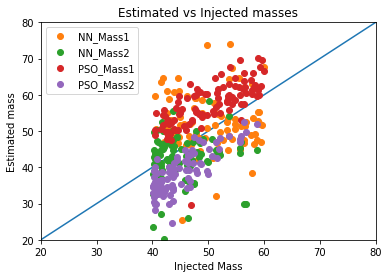

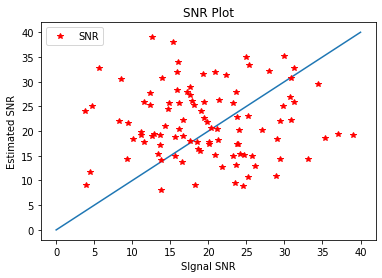

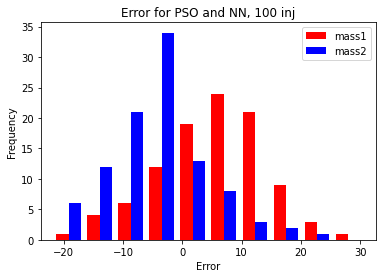

In [19]:
x=[10,20,30,40,50,60,70,80,90]
plt.figure()
plt.plot(x,x)
#plt.plot(est_m1,'*',label='NN_Mass1')
#plt.plot(est_m2,'*',label='NN_Mass2')
#plt.plot(pso_m1,'*',label='PSO_Mass1')
#plt.plot(pso_m2,pso_m1,'*',label='PSO_Mass2')

#plt.plot(inj_m1,est_w_m1,'yo',label='NN_wMass1')
#plt.plot(inj_m2,est_w_m2,'bo',label='NN_wMass2')
plt.plot(inj_m1,est_m1,'o',label='NN_Mass1')
plt.plot(inj_m2,est_m2,'o',label='NN_Mass2')
plt.plot(inj_m1,pso_m1,'o',label='PSO_Mass1')
plt.plot(inj_m2,pso_m2,'o',label='PSO_Mass2')
#plt.plot(inj_m1,inj_m2,'m*',label='PSO_Mass1')
#plt.plot(pso_m1,pso_m2,'c*',label='PSO_Mass2')
#plt.plot(est_w_m1,est_w_m2,'k*',label='NN_Weighted_Mass1')
#plt.plot(inj_m2,est_w_m2,'g*',label='NN_Weighted_Mass2')

plt.xlim(20,80)
plt.ylim(20,80)
plt.legend()
plt.xlabel('Injected Mass')
plt.ylabel('Estimated mass')
plt.title('Estimated vs Injected masses')
plt.savefig('Inj_vs_est_mse_2.png')
x=[0,10,20,30,40]
plt.figure()
plt.plot(x,x)
plt.plot(final_snr,est_snr,'r*',label='SNR')
#plt.plot(final_snr,est_w_snr,'yo',label='Weighted_SNR')
plt.legend()
#plt.xlim(0,20)
#plt.ylim(0,20)
plt.xlabel('SIgnal SNR')
plt.ylabel('Estimated SNR')
plt.title('SNR Plot')
plt.savefig('SNR Plot_mse_2.png')

error_mass1=pso_m1[:]-est_m1[:]
error_mass2=pso_m2[:]-est_m2[:]
plt.figure()
plt.hist([error_mass1,error_mass2],color=['red','blue'],label=['mass1','mass2'])
#hist([NN_error_mass1,NN_error_mass2],color=['orange','yellow'],label=['NN_mass1','NN_mass2'])
plt.title('Error for PSO and NN, 100 inj')
plt.legend()
plt.xlabel('Error')
plt.ylabel('Frequency')
plt.savefig('PSO_error_mse_2.png')


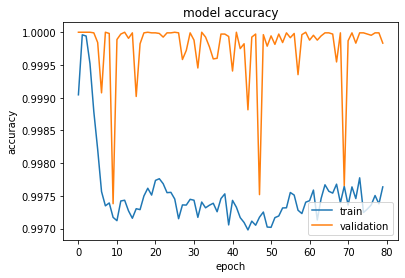

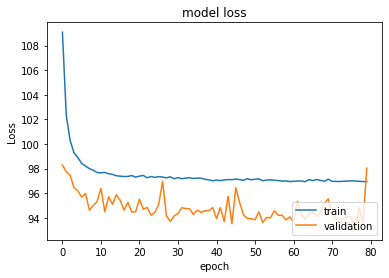

In [84]:
#  "Accuracy"
plt.figure()
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='lower right')
plt.savefig('/home/dell/Neural_net/train_coin_4/Accuracy_mse2_plot')
#  "loss"
plt.figure()
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('Loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='lower right')
plt.savefig('/home/dell/Neural_net/train_coin_4/Loss_mse2_plot')

IndexError: index 3 is out of bounds for axis 1 with size 3

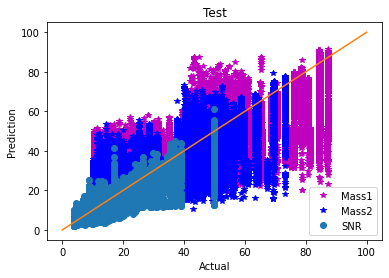

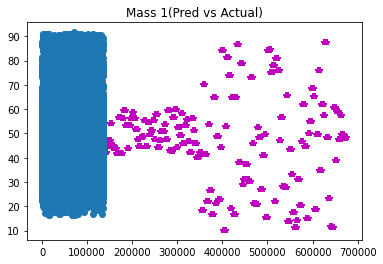

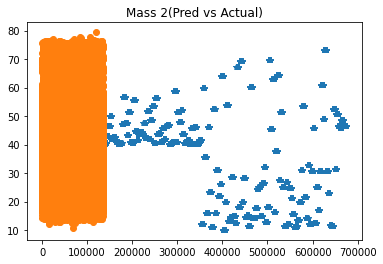

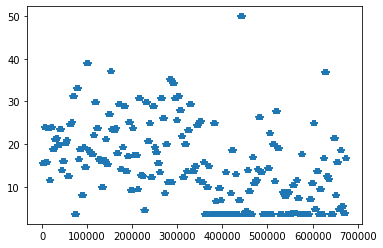

In [50]:
x=[0,10,20,30,40,50,60,70,80,90,100]
y_hat=model.predict(test_pred_ds)
m1=test1.inj_m1
m2=test1.inj_m2
snr=test1.final_snr
plt.figure()
plt.plot(m1,y_hat[:,0],"m*")
plt.plot(m2,y_hat[:,1],"b*")
plt.plot(snr,y_hat[:,2],"o")
plt.plot(x,x)
plt.title('Test')
plt.ylabel('Prediction')
plt.xlabel('Actual')
plt.legend(['Mass1', 'Mass2', 'SNR'], loc='lower right')
plt.savefig('/home/dell/Neural_net/train_coin_4/test_mse_plot')
plt.figure()
plt.plot(m1,"m*",label='Actual')
plt.plot(y_hat[:,0],'o',label='predicted')
plt.title('Mass 1(Pred vs Actual)')
#plt.ylabel('Prediction')
#plt.xlabel('Mass')
#plt.legend(['Mass1', 'Mass2', 'SNR'], loc='lower right')
plt.savefig('/home/dell/Neural_net/train_coin_4/test_mse_m1_plot')
plt.figure()
plt.plot(m2,"*",label='Actual')
plt.plot(y_hat[:,1],'o',label='predicted')
plt.title('Mass 2(Pred vs Actual)')
#plt.ylabel('Prediction')
#plt.xlabel('Mass')
#plt.legend(['Mass1', 'Mass2', 'SNR'], loc='lower right')
plt.savefig('/home/dell/Neural_net/train_coin_4/test_mse_m2_plot')
plt.figure()
plt.plot(snr,"*",label='Actual')
plt.plot(y_hat[:,3],'o',label='predicted')
plt.title('SNR (Pred vs Actual)')
#plt.ylabel('Prediction')
#plt.xlabel('Mass')
#plt.legend(['Mass1', 'Mass2', 'SNR'], loc='lower right')
plt.savefig('/home/dell/Neural_net/train_coin_4/test_mse_snr_plot')

In [34]:
hist_data1 = [error_mass1,error_mass2]

group_labels = ['Mass1','Mass2']
colors = [ '#A56CC1', '#63F5EF']
# Create distplot with custom bin_size
fig = ff.create_distplot(hist_data1, group_labels,colors=colors,show_rug=False)

fig.update_layout(title='Error in estimating component masses for 100 injections using the Prediction model',xaxis_title="Error(Mo)",yaxis_title="Frequency")
fig.show()

In [39]:
fig = go.Figure()
x=[40,50,60]
fig.add_trace(go.Scatter(x=x,y=x,mode='lines',name='x=y'))
fig.add_trace(go.Scatter(x=inj_m1, y=est_m1,mode='markers',name='NN Mass 1'))
fig.add_trace(go.Scatter(x=inj_m2, y=est_m2,mode='markers',name='NN Mass 2'))
fig.add_trace(go.Scatter(x=inj_m1, y=pso_m1,mode='markers',name='PSO Mass 1'))
fig.add_trace(go.Scatter(x=inj_m2, y=pso_m2,mode='markers',name='PSO Mass 2'))
fig.update_layout(title='Injected versus Estimated Component Masses predicted by the model',xaxis_title="Injected Mass (Mo)",yaxis_title="Estimated Mass (Mo)")
fig.show()

In [62]:
fig = go.Figure()
x=[10,20,30,40,50,60,70,80,90]
fig.add_trace(go.Scatter(x=x,y=x,mode='lines',name='x=y'))
fig.add_trace(go.Scatter(inj_m1,mode='markers',name='NN Mass 1'))
fig.add_trace(go.Scatter(inj_m2,mode='markers',name='NN Mass 2'))
#fig.add_trace(go.Scatter(x=inj_m1, y=pso_m1,mode='markers',name='PSO Mass 1'))
#fig.add_trace(go.Scatter(x=inj_m2, y=pso_m2,mode='markers',name='PSO Mass 2'))
fig.update_layout(title='Injected versus Estimated Component Masses for 100 injections for I1 detector',xaxis_title="Injected Mass (Mo)",yaxis_title="Estimated Mass (Mo)")
fig.show()

ValueError: The first argument to the plotly.graph_objs.Scatter 
constructor must be a dict or 
an instance of :class:`plotly.graph_objs.Scatter`

In [23]:
fig = go.Figure()
x=[5,10,15,20,25,30,35,40]
fig.add_trace(go.Scatter(x=x,y=x,mode='lines',name='x=y'))
fig.add_trace(go.Scatter(x=final_snr, y=est_snr,mode='markers',name='SNR'))
fig.update_layout(title='SNR predicted by the model',xaxis_title="PSO estimated SNR",yaxis_title="NN estimated SNR")
fig.show()

In [32]:

error_snr=final_snr-est_snr
hist_data1 = [error_snr]

group_labels = ['SNR']
colors = [ '#A56CC1']
# Create distplot with custom bin_size
fig = ff.create_distplot(hist_data1, group_labels,colors=colors,show_rug=False)

fig.update_layout(title='Error in estimating component masses for 100 injections using the Prediction model',xaxis_title="Error(Mo)",yaxis_title="Frequency")
fig.show()

In [26]:
acc=(history.history['accuracy'])
acc


[0.9930161833763123,
 0.9993911981582642,
 0.9999444484710693,
 0.999965250492096,
 0.9999282360076904,
 0.9998958110809326,
 0.9998657703399658,
 0.999833345413208,
 0.9998842477798462,
 0.9998518228530884,
 0.9999120235443115,
 0.9998634457588196,
 0.9999282360076904,
 0.9999444484710693,
 0.9999722242355347,
 0.9999698996543884,
 0.999965250492096,
 0.9999675750732422,
 0.9999745488166809,
 0.9999930262565613,
 0.9999745488166809,
 0.9999791383743286,
 0.9999930262565613,
 0.9999884366989136,
 0.9999768733978271,
 0.9999861121177673,
 0.9999837875366211,
 0.9999907612800598,
 0.9999768733978271,
 0.9999768733978271,
 0.9999837875366211,
 0.9999907612800598,
 0.9999884366989136,
 0.9999791383743286,
 0.9999791383743286,
 0.999965250492096,
 0.9999861121177673,
 0.9999861121177673,
 0.9999814629554749,
 0.999965250492096,
 0.9999884366989136,
 0.9999837875366211,
 0.999958336353302,
 0.9999606609344482,
 0.9999768733978271,
 0.9999560117721558,
 0.999965250492096,
 0.9999513626098633,

In [169]:
v_acc=(history.history['val_accuracy'])
v_acc


[1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 0.9999259114265442,
 0.9993426203727722,
 0.9998703598976135,
 0.9993796348571777,
 0.9994537234306335,
 0.9990184903144836,
 0.9993796348571777,
 0.9995277523994446,
 0.9993981719017029,
 0.9993055462837219,
 0.9980740547180176,
 0.9994629621505737,
 0.9994074106216431,
 0.9992870092391968,
 0.9978981614112854,
 0.9992592334747314,
 0.9991111159324646,
 0.9988425970077515,
 0.9989907145500183,
 0.9986574053764343,
 0.9983518719673157,
 0.9994722008705139,
 0.9974907636642456,
 0.9991018772125244,
 0.9997222423553467,
 0.9997129440307617,
 0.9986388683319092,
 0.9993055462837219,
 0.9994629621505737,
 0.9994444251060486,
 0.9995277523994446,
 0.9993610978126526,
 0.9994166493415833,
 0.9993518590927124,
 0.9989259243011475,
 0.9992963075637817,
 0.9961110949516296,
 0.9991759061813354,
 0.9993796348571777,
 0.9994722008705139,
 0.9985926151275635,
 0.9987037181854248,
 0.9994629621505737,
 0.9992685317993164,
 0.9991203